In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Import GDrive files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd 'drive/My Drive/Colab Notebooks/4th year project/OULAD dataset/ouladModule'

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/4th year project/OULAD dataset/ouladModule'
/content/drive/My Drive/Colab Notebooks/4th year project/OULAD dataset/ouladModule


In [ ]:
ls

oulad_AAA_220.csv  oulad_CCC_220.csv  oulad_EEE_220.csv  oulad_GGG_220.csv
oulad_AAA.csv      oulad_CCC.csv      oulad_EEE.csv      oulad_GGG.csv
oulad_BBB_220.csv  oulad_DDD_220.csv  oulad_FFF_220.csv
oulad_BBB.csv      oulad_DDD.csv      oulad_FFF.csv


#### Load dataset

In [ ]:
aaa_df = pd.read_csv('oulad_AAA_220.csv')

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [ ]:
aaa_df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,dataplus,dualpane,externalquiz,folder,forumng,glossary,homepage,htmlactivity,oucollaborate,oucontent,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url,sum_click
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,2,0.0,0.0,0.0,0.0,153.0,0.0,128.0,0.0,0.0,459.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,30.0,5.0,786.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,2,10.0,0.0,0.0,0.0,385.0,0.0,319.0,0.0,0.0,535.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,87.0,48.0,1396.0
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,2,2.0,0.0,0.0,0.0,357.0,1.0,389.0,0.0,0.0,783.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,136.0,90.0,1772.0
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,2,0.0,0.0,0.0,0.0,149.0,4.0,179.0,0.0,0.0,461.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,65.0,11.0,909.0
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,2,7.0,0.0,0.0,0.0,723.0,4.0,455.0,0.0,0.0,848.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,89.0,43.0,2180.0


In [ ]:
aaa_df.code_module.value_counts()

AAA    601
Name: code_module, dtype: int64

#### Remove column features that are not used in module

In [ ]:
aaa_df = aaa_df.loc[:, (aaa_df != 0).any(axis=0)]

#### Plot the correlation matrix

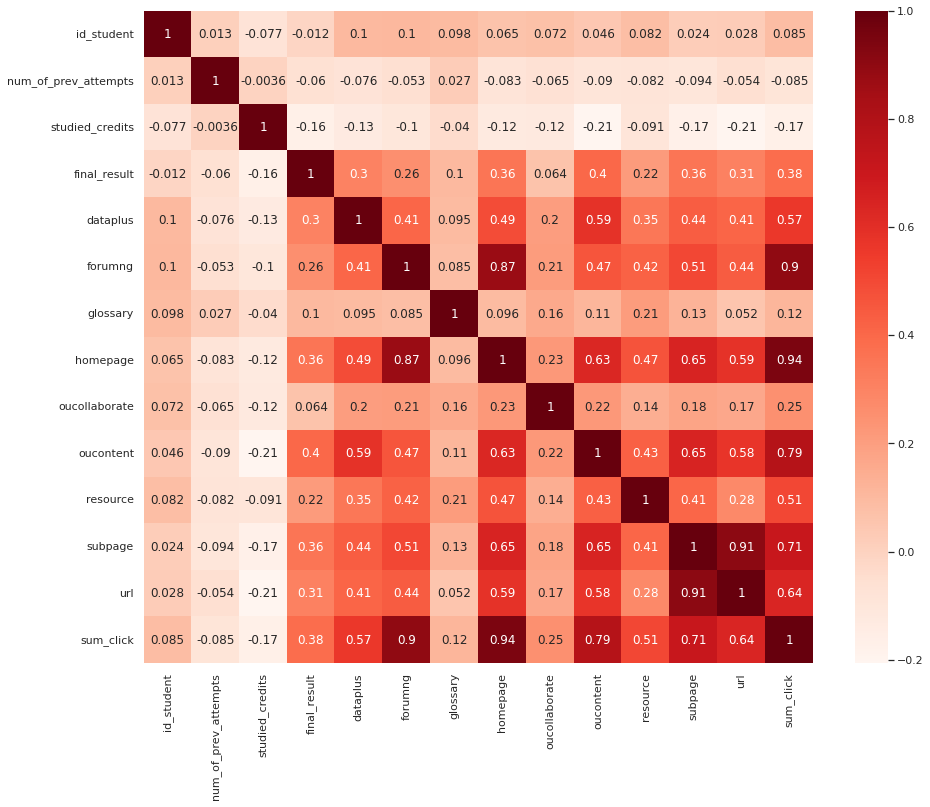

In [ ]:
plt.figure(figsize=(15,12))
cor = aaa_df.corr()
# cor = cor.iloc[:,-1].to_numpy().reshape(9,1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
aaa_df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,dataplus,forumng,glossary,homepage,oucollaborate,oucontent,resource,subpage,url,sum_click
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,2,0.0,153.0,0.0,128.0,0.0,459.0,11.0,30.0,5.0,786.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,2,10.0,385.0,0.0,319.0,0.0,535.0,12.0,87.0,48.0,1396.0
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,2,2.0,357.0,1.0,389.0,0.0,783.0,14.0,136.0,90.0,1772.0
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,2,0.0,149.0,4.0,179.0,0.0,461.0,40.0,65.0,11.0,909.0
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,2,7.0,723.0,4.0,455.0,0.0,848.0,11.0,89.0,43.0,2180.0


#### Make predictions

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score


def evaluation_summary(description, predictions, true_labels):
  print("Evaluation for: " + description)
  precision_macro = precision_score(true_labels, predictions, average='macro')
  precision_weighted = precision_score(true_labels, predictions, average='weighted')

  recall = recall_score(true_labels, predictions, average='macro')
  accuracy = accuracy_score(true_labels, predictions)
  f1 = fbeta_score(true_labels, predictions, beta=1, average='macro')#, labels=np.unique(predictions)) #1 means f_1 measure

  print("Classifier '%s' has Acc=%0.3f P_macro=%0.3f P_weighted=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision_macro,precision_weighted,recall,f1))
  # Specify three digits instead of the default two.
  print(classification_report(true_labels, predictions, digits=3))
  print('\nConfusion matrix:\n') # Note the order here is true, predicted, odd.
  cm = confusion_matrix(true_labels, predictions)
  labels = np.unique(true_labels)
  print(pd.DataFrame(cm, index=labels, columns=labels))

  plt.subplots(figsize=(8,7))
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="YlGnBu");  #annot=True to annotate cells, ftm='g' to disable scientific notation

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['fail', 'pass']); ax.yaxis.set_ticklabels(['fail', 'pass'])

In [ ]:
from sklearn.pipeline import Pipeline

def encode_df(df):
  # categorise df columns
  df.code_module = pd.Categorical(df.code_module)
  df.gender = pd.Categorical(df.gender)
  df.region = pd.Categorical(df.region)
  df.disability = pd.Categorical(df.disability)

  encoding_pipeline = Pipeline([
      ('encoding_label',MultiColumnLabelEncoder(columns=['highest_education','imd_band','age_band'])),
  ])
  df = encoding_pipeline.fit_transform(df)

  # Convert categorical variable into indicator variables. One-hot encoding
  df = pd.get_dummies(df)

  return df

In [ ]:
def split_dataset(df, test_code_presentation):   
  test_df = df.loc[df['code_presentation']==test_code_presentation]
  test_df = test_df.drop(['code_presentation'], axis = 1)

  Y_test = test_df['final_result'].replace({1:0, 2:1, 3:1})
  X_test = test_df.drop('final_result', axis=1)

  train_df = df.loc[df['code_presentation']!=test_code_presentation]
  train_df = train_df.drop(['code_presentation'], axis = 1)

  Y_train = train_df['final_result'].replace({1:0, 2:1, 3:1})
  X_train = train_df.drop('final_result', axis=1)

  
  return encode_df(X_train), Y_train, encode_df(X_test), Y_test


#### Prepare data

In [ ]:
from sklearn import preprocessing

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = preprocessing.LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = preprocessing.LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)


class MultiColumnOHEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = preprocessing.OneHotEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = preprocessing.OneHotEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [ ]:
# remove withdrawl
aaa_df['final_result'].replace({1:0, 2:1, 3:1}) # Fail; Pass, Distinction -> Incomplete; Complete

0      1
1      1
2      1
3      1
4      1
      ..
596    1
597    1
598    1
599    1
600    0
Name: final_result, Length: 601, dtype: int64

In [ ]:
aaa_df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,dataplus,forumng,glossary,homepage,oucollaborate,oucontent,resource,subpage,url,sum_click
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,2,0.0,153.0,0.0,128.0,0.0,459.0,11.0,30.0,5.0,786.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,2,10.0,385.0,0.0,319.0,0.0,535.0,12.0,87.0,48.0,1396.0
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,2,2.0,357.0,1.0,389.0,0.0,783.0,14.0,136.0,90.0,1772.0
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,2,0.0,149.0,4.0,179.0,0.0,461.0,40.0,65.0,11.0,909.0
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,2,7.0,723.0,4.0,455.0,0.0,848.0,11.0,89.0,43.0,2180.0


In [ ]:
X_train, Y_train, X_test, Y_test = split_dataset(aaa_df, '2014J')

In [ ]:
X_train.head()

,id_student,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,dataplus,forumng,glossary,homepage,oucollaborate,oucontent,resource,subpage,url,sum_click,code_module_AAA,gender_F,gender_M,region_East Anglian Region,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,disability_N,disability_Y
0,11391,1,9,2,0,240,0.0,153.0,0.0,128.0,0.0,459.0,11.0,30.0,5.0,786.0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,28400,1,2,1,0,60,10.0,385.0,0.0,319.0,0.0,535.0,12.0,87.0,48.0,1396.0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,31604,0,5,1,0,60,2.0,357.0,1.0,389.0,0.0,783.0,14.0,136.0,90.0,1772.0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,32885,2,5,0,0,60,0.0,149.0,4.0,179.0,0.0,461.0,40.0,65.0,11.0,909.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,38053,0,8,1,0,60,7.0,723.0,4.0,455.0,0.0,848.0,11.0,89.0,43.0,2180.0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


#### Random Forest

Evaluation for: RandomForest Classifier test dataset
Classifier 'RandomForest Classifier test dataset' has Acc=0.555 P_macro=0.614 P_weighted=0.862 R=0.709 F1=0.522
              precision    recall  f1-score   support

           0      0.253     0.935     0.398        46
           1      0.975     0.484     0.647       246

    accuracy                          0.555       292
   macro avg      0.614     0.709     0.522       292
weighted avg      0.862     0.555     0.608       292


Confusion matrix:

     0    1
0   43    3
1  127  119


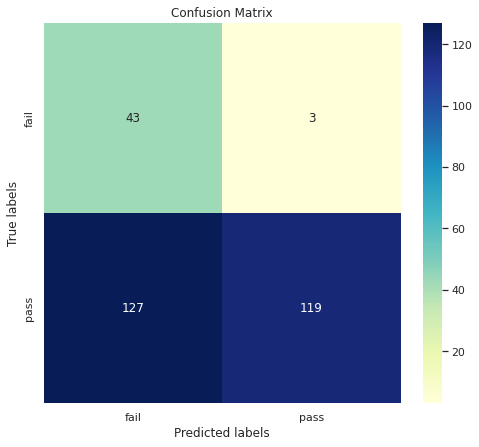

In [ ]:
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()

randomforest.fit(X_train, Y_train)

test_randomforest_predictions = randomforest.predict(X_test)

evaluation_summary("RandomForest Classifier test dataset",  test_randomforest_predictions, Y_test)

[-0.00684932  0.00136986 -0.00068493  0.00342466  0.         -0.00205479
 -0.00205479  0.00136986 -0.00068493 -0.01438356 -0.00136986 -0.03150685
 -0.00890411 -0.00753425  0.         -0.02191781  0.          0.00479452
  0.00205479  0.          0.          0.         -0.00068493 -0.00410959
  0.          0.          0.          0.          0.00205479  0.
  0.00068493 -0.00136986  0.          0.        ]


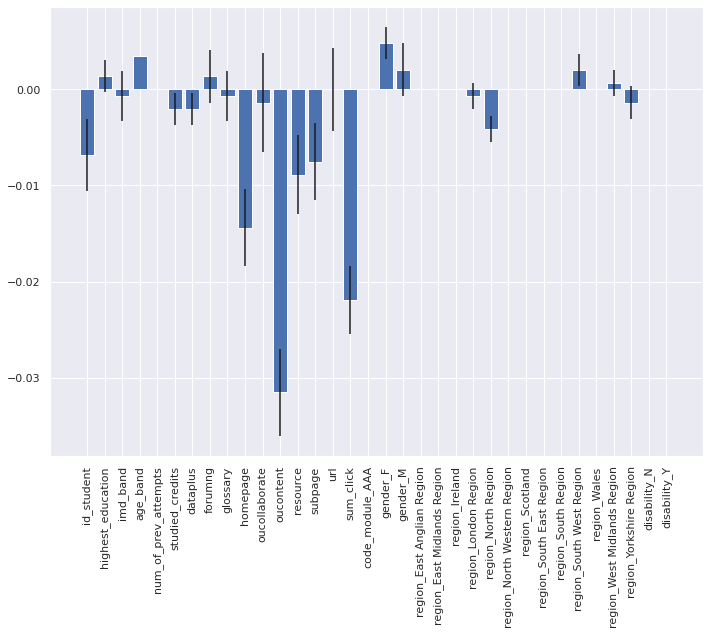

,importance,column
17,0.004795,gender_F
3,0.003425,age_band
28,0.002055,region_South West Region
18,0.002055,gender_M
1,0.001370,highest_education
7,0.001370,forumng
30,0.000685,region_West Midlands Region
32,0.000000,disability_N
29,0.000000,region_Wales
27,0.000000,region_South Region


In [ ]:
from sklearn.inspection import permutation_importance

importance = permutation_importance(randomforest, X_test, Y_test)
print(importance.importances_mean)

feature_names = randomforest.feature_names_in_

plt.bar([x for x in range(len(importance['importances_mean']))], importance['importances_mean'], yerr=importance['importances_std'])
plt.xticks(range(len(feature_names)), feature_names, rotation='vertical')
plt.show()

importance_table = pd.DataFrame({'importance': importance['importances_mean'],
                                 'column': feature_names })
importance_table.sort_values(by = 'importance', ascending = False)[:20]